# Introduction to Data Science and Machine Learning

<p align="center">
    <img width="699" alt="image" src="https://user-images.githubusercontent.com/49638680/159042792-8510fbd1-c4ac-4a48-8320-bc6c1a49cdae.png">
</p>

---

## Regularisation and Overfitting issues Homework

The aim of this homework is to check whether a given model overfits and apply strategies to avoid such behaviour.

### Import libraries

In [1]:
# Import libraries we will need in the following
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, classification_report

from utils import helpers_Garden as hg
from utils.plottings import plot_learning_curve


# set plot size
plt.rcParams['figure.figsize'] = (20, 13)
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Read dataset

We are going to read a simple dataset.
This is the famous titanic dataset, you already met.

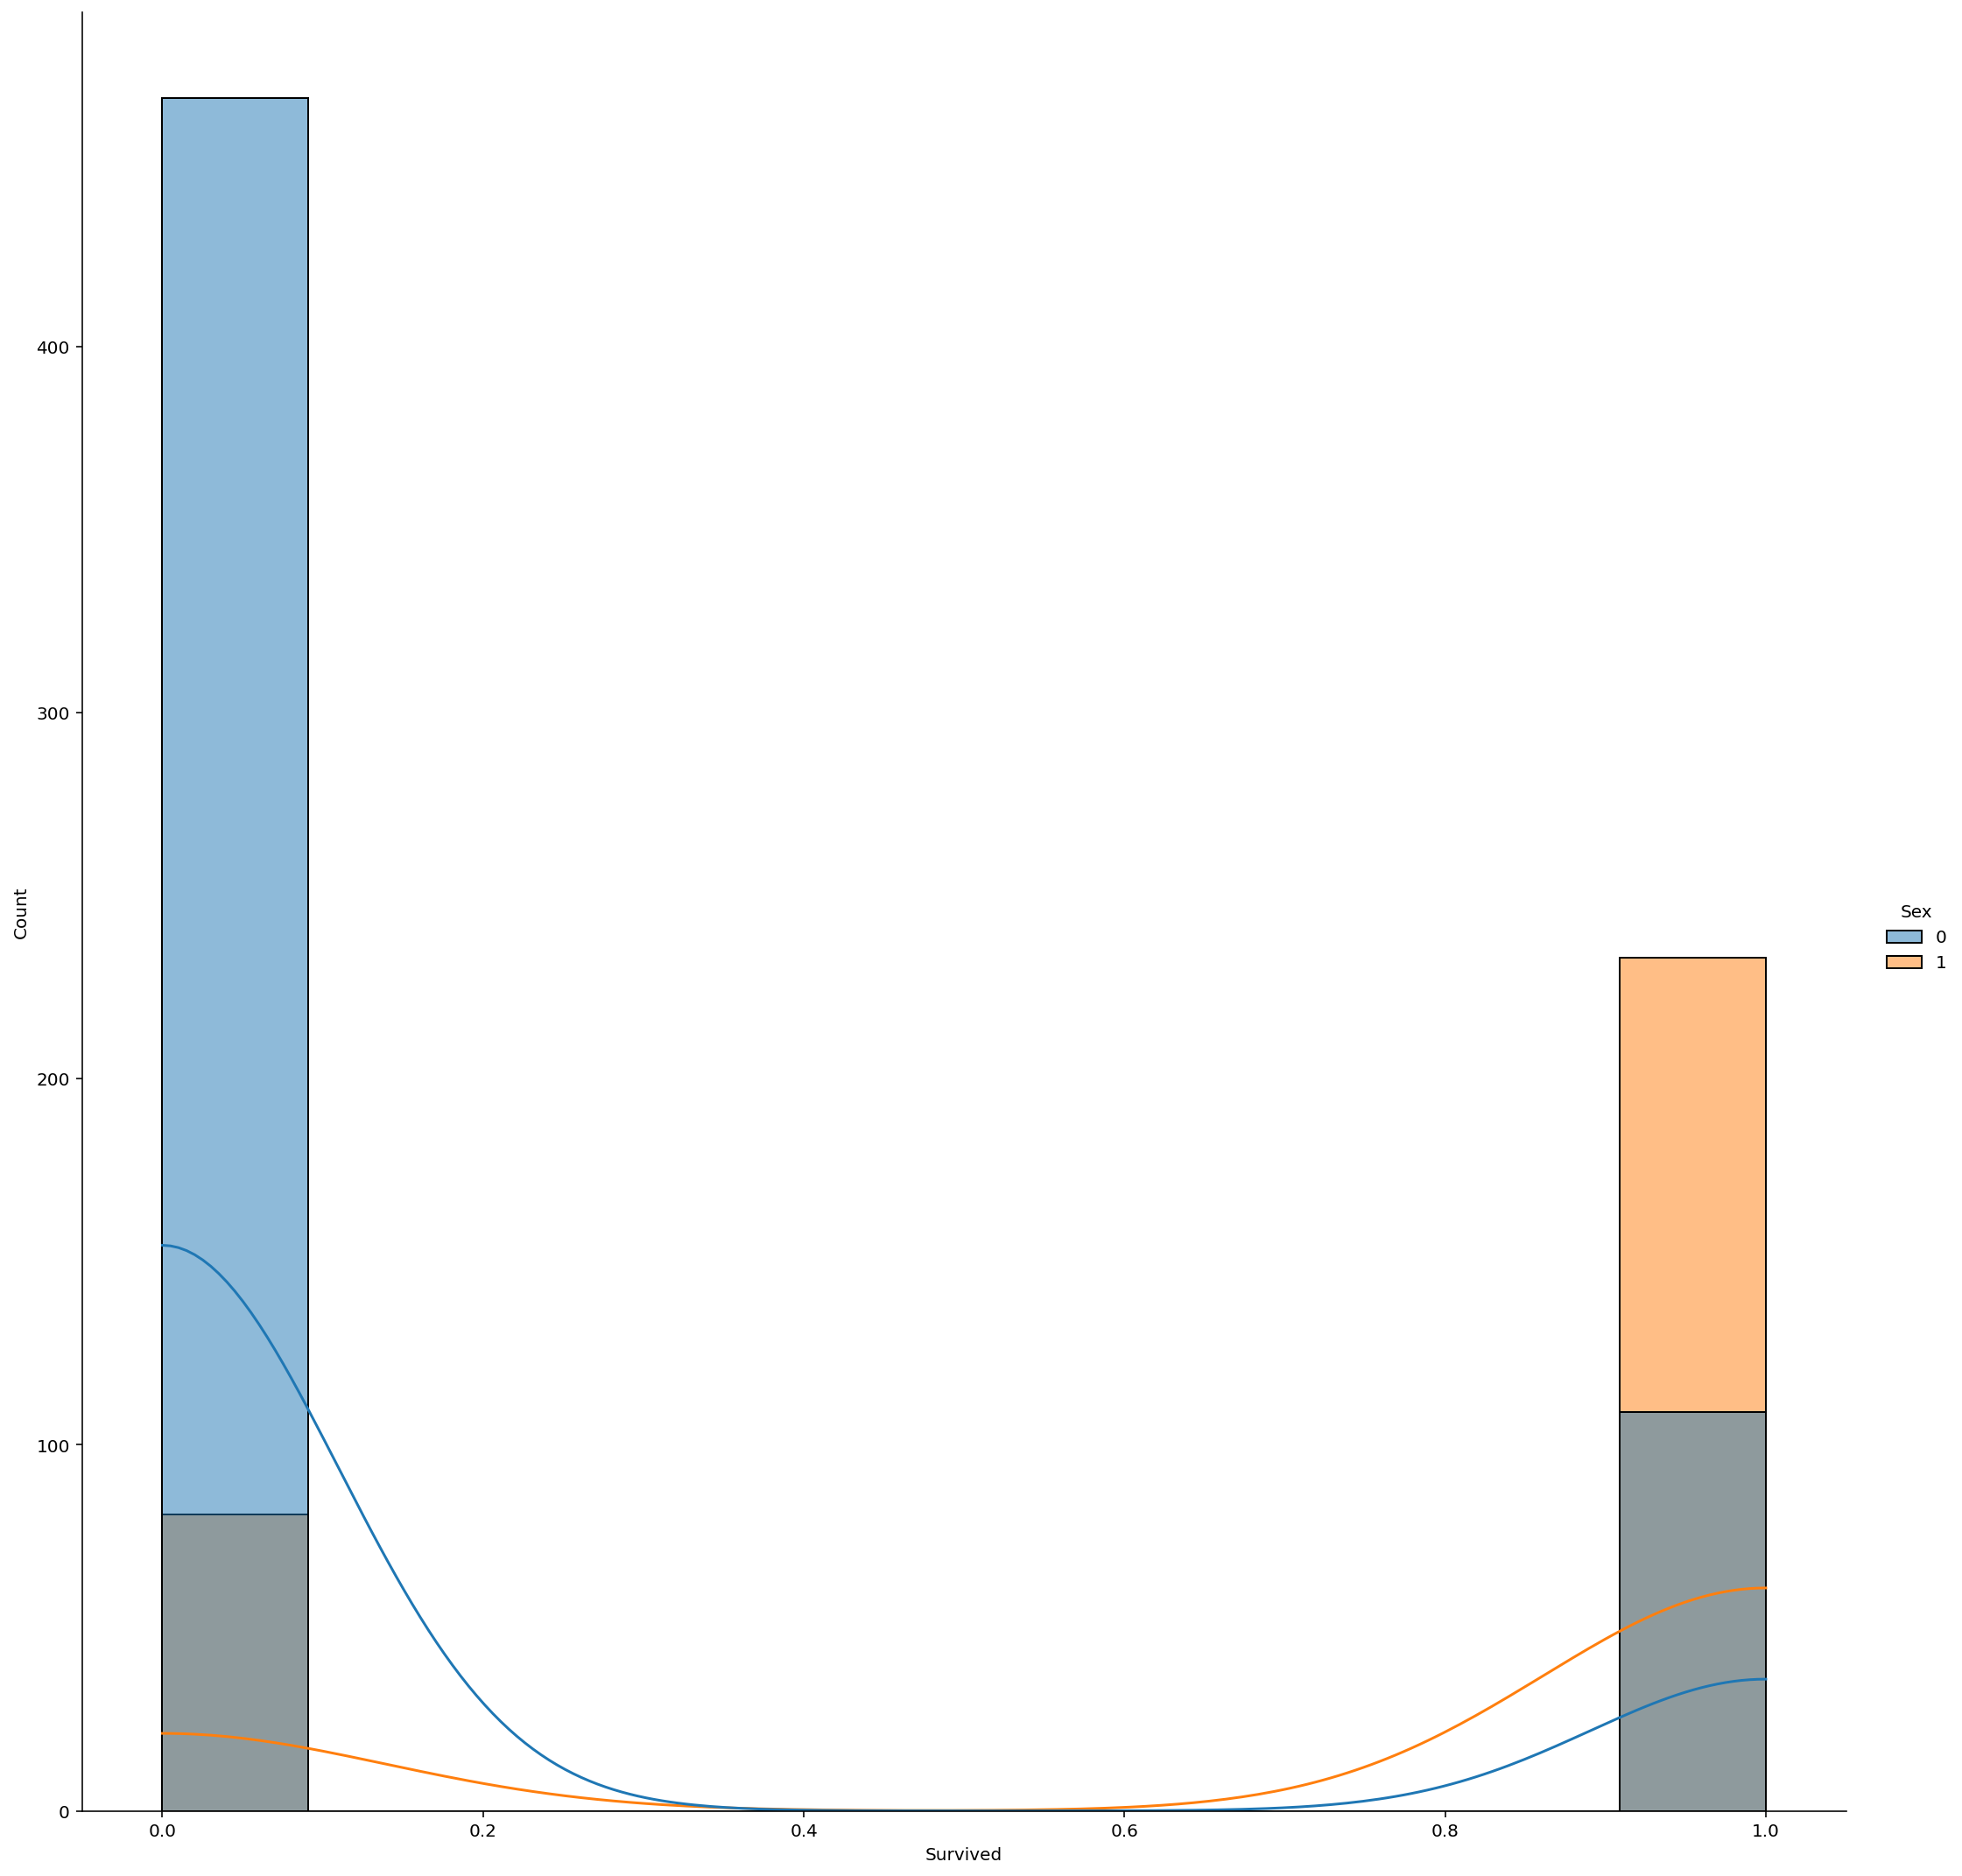

In [2]:
df = pd.read_csv('http://bit.ly/kaggletrain')
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

sns.displot(data=df, x="Survived", kde=True, hue="Sex", height=15);

In [3]:
features = ['Pclass', 'Fare', 'Sex', 'Parch']
X = df[features]
y = df['Survived']

## Gini Impurity and Entropy

We have seen that in algorithm based on trees, we look for the best split. 
The term “best” split means that after split, the two branches are more “ordered” than any other possible split.
How do we define more ordered? 
It depends on which metric we choose.
In general, there are two types of metric: _Gini impurity_ and _entropy_. 
These metrics are disorder metrics, that is the smaller these metrics are, the more “ordered” the dataset is.

$$ \mathcal{G} = 1 - \sum_j p^2_j \, . $$

$$ \mathcal{S} = - \sum_j p_j \log p_j \, . $$

The difference between the two metrics is pretty subtle. 
To learn more, you may read this [post](https://quantdare.com/decision-trees-gini-vs-entropy/). 
In most applications, both metric behave similarly. 

Below is the code to calculate each metric.

In [4]:
def gini_impurity(y):
    """Function to calculate Gini impurity."""
    m = y.shape[0]
    cnts = dict(zip(*np.unique(y, return_counts = True)))
    impurity = 1 - sum((cnt/m)**2 for cnt in cnts.values())
    return impurity

def entropy(y):
    """Function to calculate Entropy."""
    m = y.shape[0]
    cnts = dict(zip(*np.unique(y, return_counts = True)))
    entr = - sum((cnt/m)*np.log(cnt/m) for cnt in cnts.values())
    return entr

### Train and test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Decision tree training

In [6]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train);

In [7]:
decision_tree.tree_.node_count

279

In [8]:
accuracy_score(y_train, decision_tree.predict(X_train))

0.9185393258426966

In [9]:
cross_val_score(decision_tree, X_train, y_train, cv=5, scoring='accuracy').mean()

0.8048458583669852

In [10]:
# Pruning 
# pruned tree has less nodes
dt = DecisionTreeClassifier(max_depth=5, ccp_alpha=0.001, random_state=0)
dt.fit(X_train, y_train).tree_.node_count

47

In [11]:
# pruning improved the cross-validated accuracy
cross_val_score(dt, X, y, cv=5, scoring='accuracy').mean()

0.8002134203753688

In [12]:
print(classification_report(y_test, dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       105
           1       0.83      0.70      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.82      0.82      0.81       179



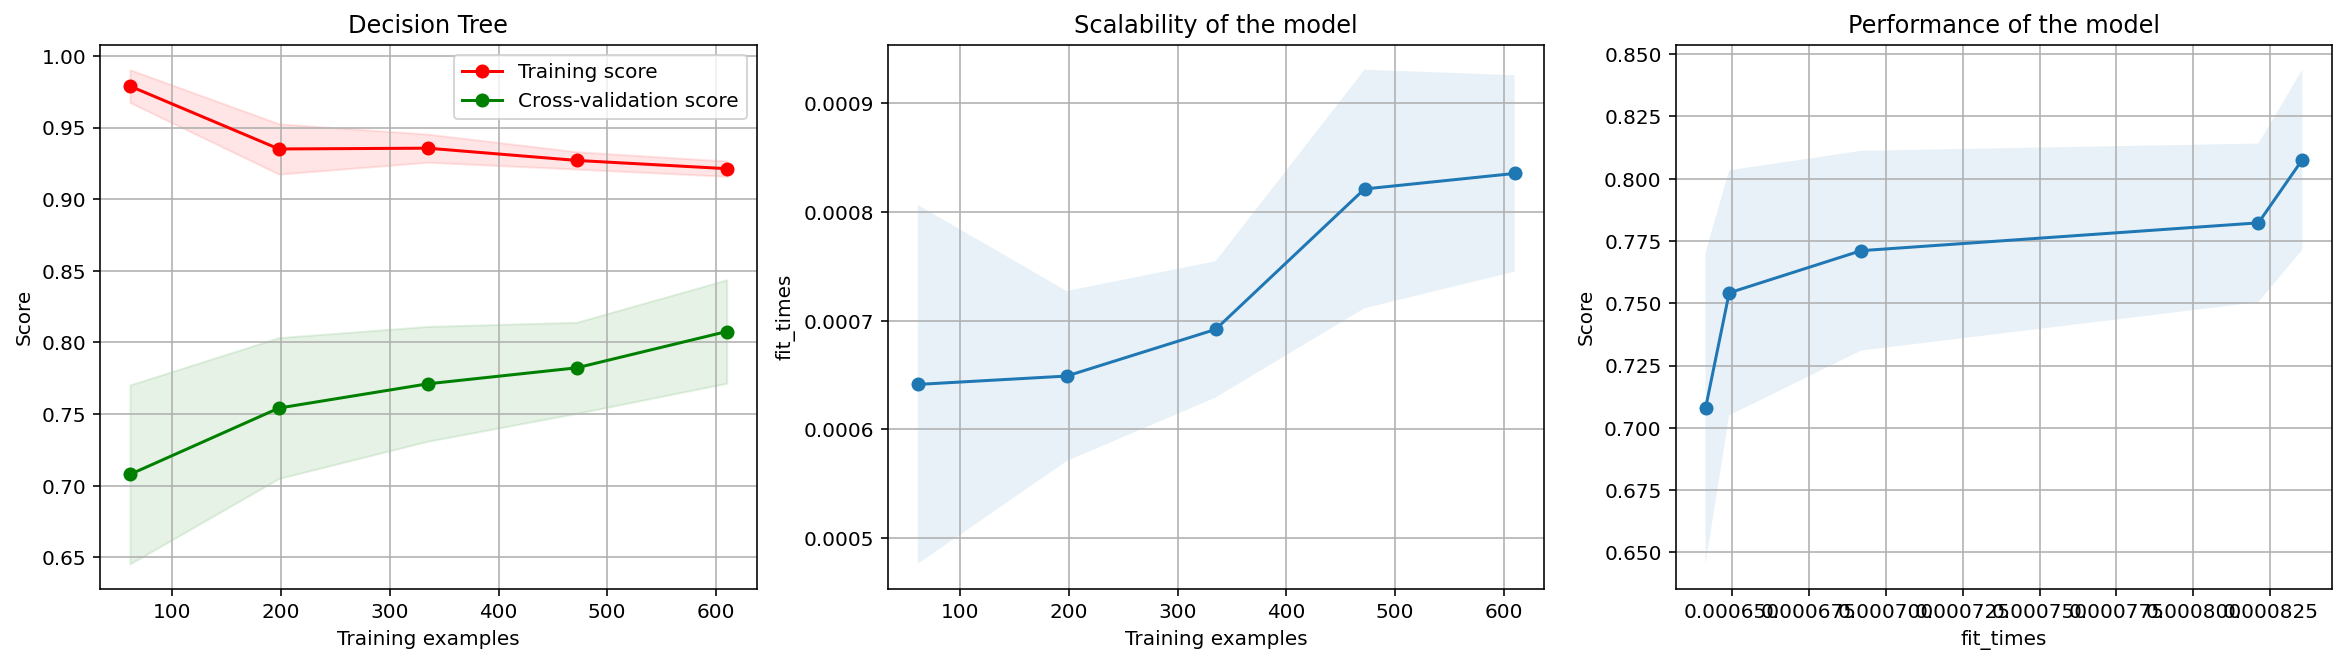

In [13]:
plot_learning_curve(decision_tree, "Decision Tree", X_train, y_train, cv=7);

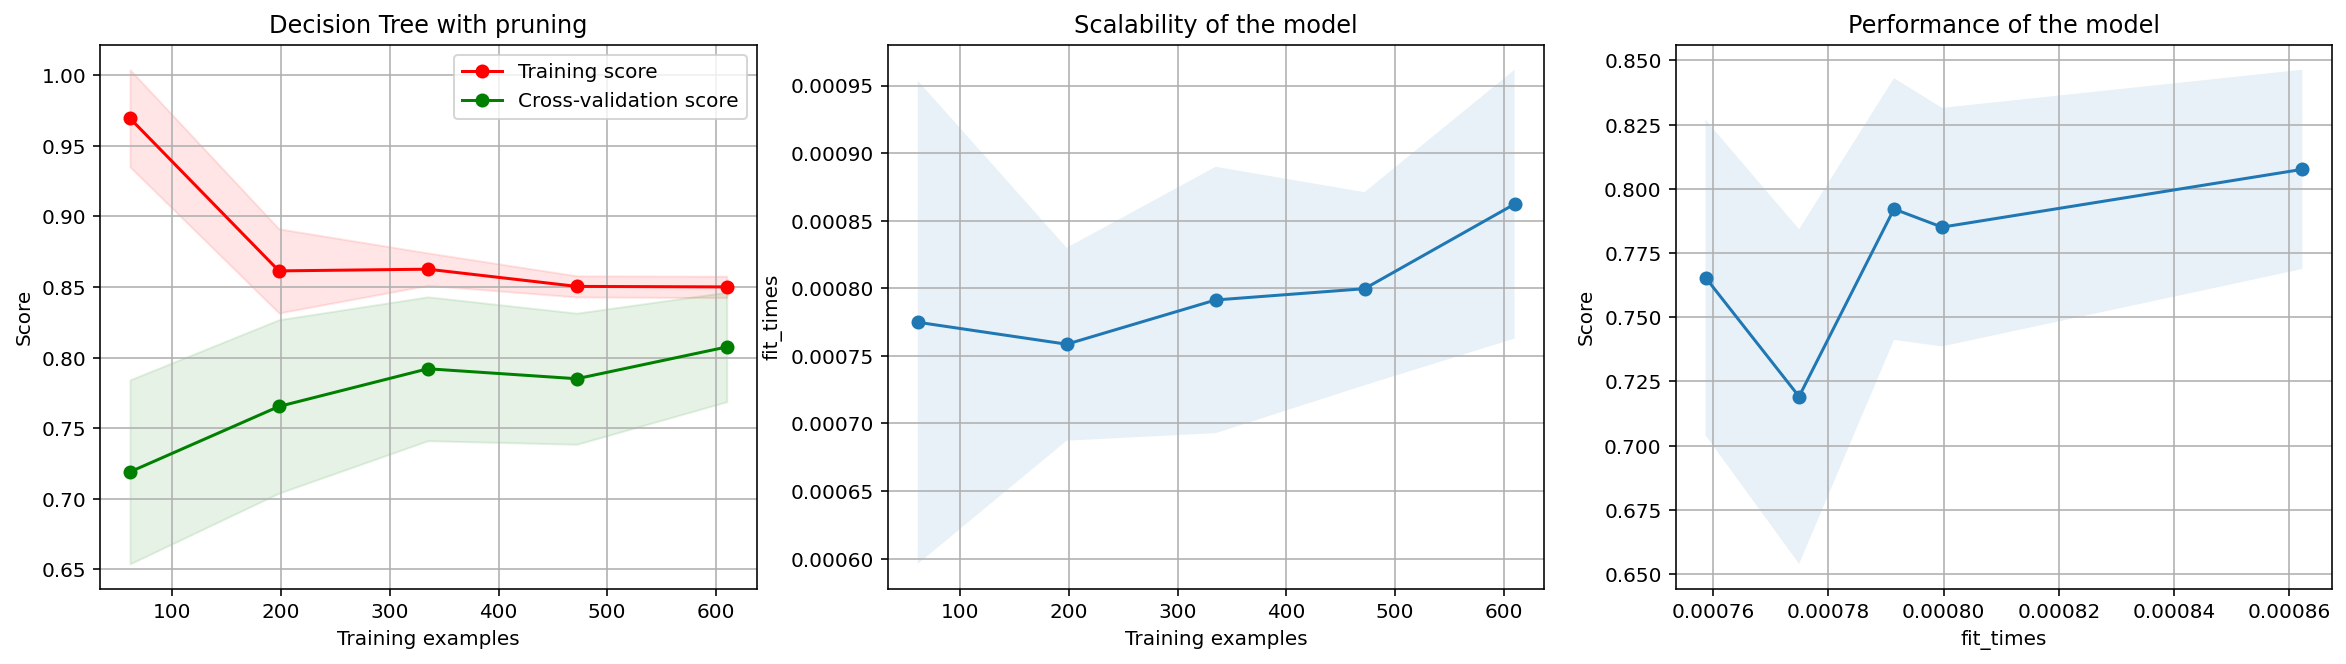

In [14]:
plot_learning_curve(dt, "Decision Tree with pruning", X_train, y_train, cv=7);

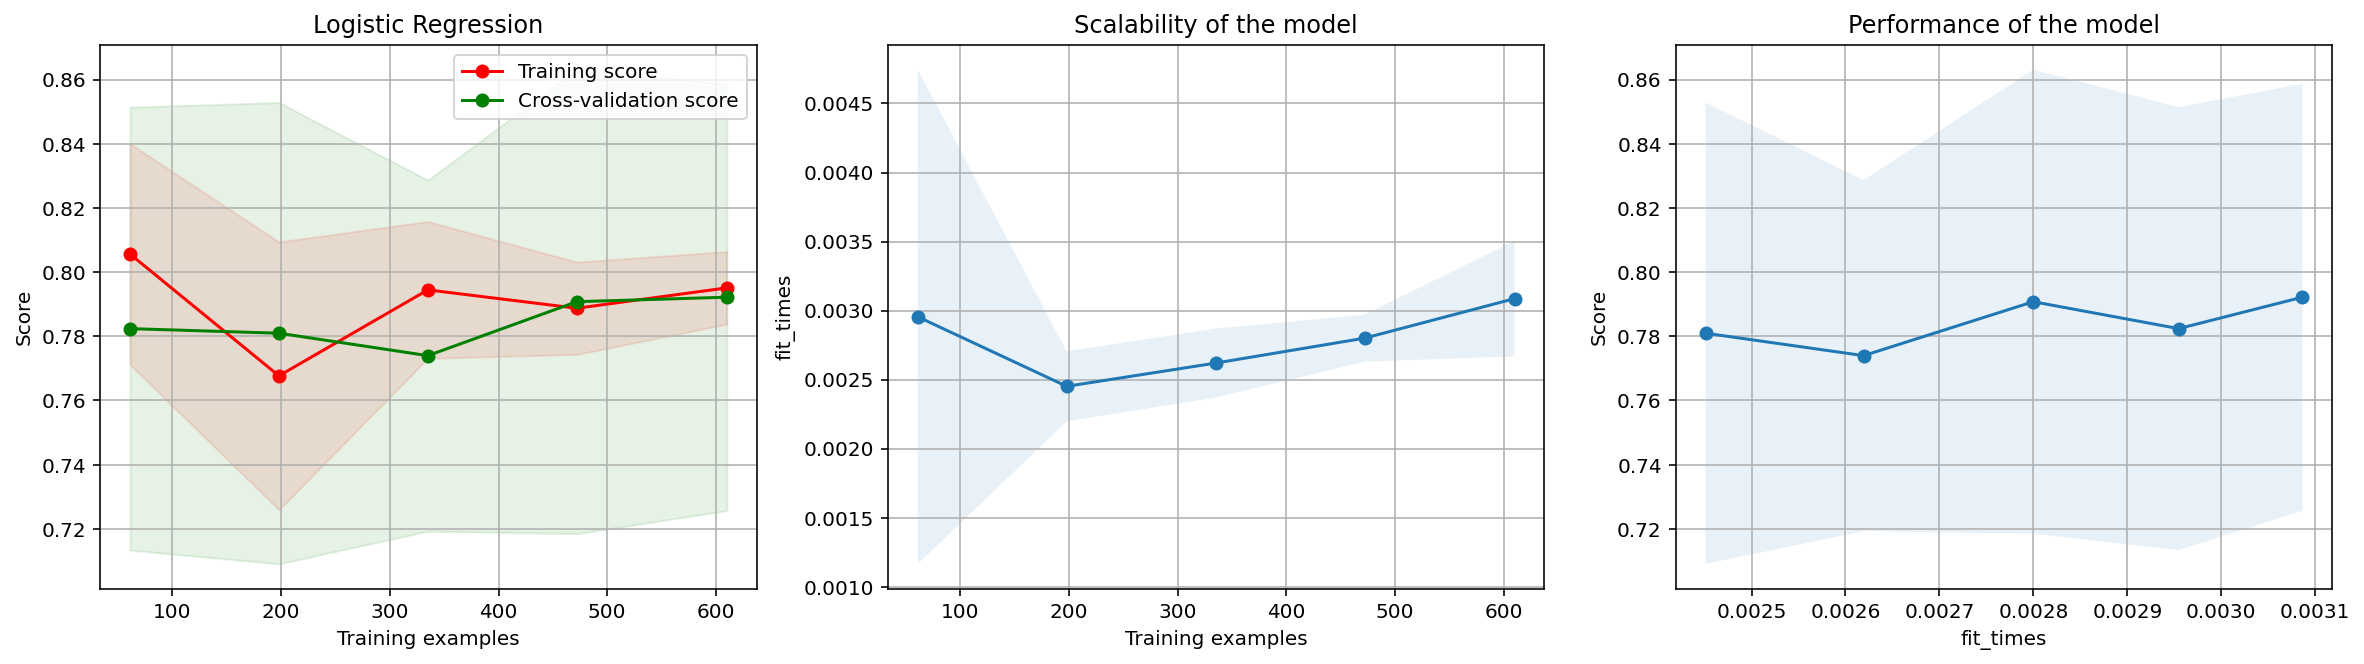

In [15]:
plot_learning_curve(LogisticRegression(), "Logistic Regression", X_train, y_train, cv=7);

In [31]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "min_samples_split": [2, 3, 4, 5, 6, 7],
    "min_samples_leaf": [1, 2, 3, 4, 5],
    "splitter": ["best", "random"],
    "class_weight": [{0: 0.5, 1: 1.0},{0:1, 1: 105/74}],
    "ccp_alpha": [0.01, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3]
} # Hyperparameter space grid

gs = GridSearchCV(decision_tree, param_grid=param_grid,
scoring="f1", cv=7)

gs.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0.01, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3],
                         'class_weight': [{0: 0.5, 1: 1.0},
                                          {0: 1, 1: 1.4189189189189189}],
                         'max_depth': [3, 4, 5, 7],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5, 6, 7],
                         'splitter': ['best', 'random']},
             scoring='f1')

In [32]:
gs.best_params_

{'ccp_alpha': 0.01,
 'class_weight': {0: 1, 1: 1.4189189189189189},
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}

In [34]:
param_grid = {
    "max_depth": [2, 3, 4, 5],
    "min_samples_split": [3],
    "min_samples_leaf": [1],
    "class_weight": [{0: 0.5, 1: 1.0},{0:1, 1: 105/74}],
    "splitter": ["best"],
    "ccp_alpha": [0.001, 0.002, 0.005, 0.007, 0.01]
} # Hyperparameter space grid

gs2 = GridSearchCV(decision_tree, param_grid=param_grid,
scoring="f1", cv=7)

gs2.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0.001, 0.002, 0.005, 0.007, 0.01],
                         'class_weight': [{0: 0.5, 1: 1.0},
                                          {0: 1, 1: 1.4189189189189189}],
                         'max_depth': [5, 7, 8, 9, 10, 11, 12],
                         'min_samples_leaf': [1], 'min_samples_split': [3],
                         'splitter': ['best']},
             scoring='f1')

In [35]:
gs2.best_params_

{'ccp_alpha': 0.002,
 'class_weight': {0: 1, 1: 1.4189189189189189},
 'max_depth': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'splitter': 'best'}

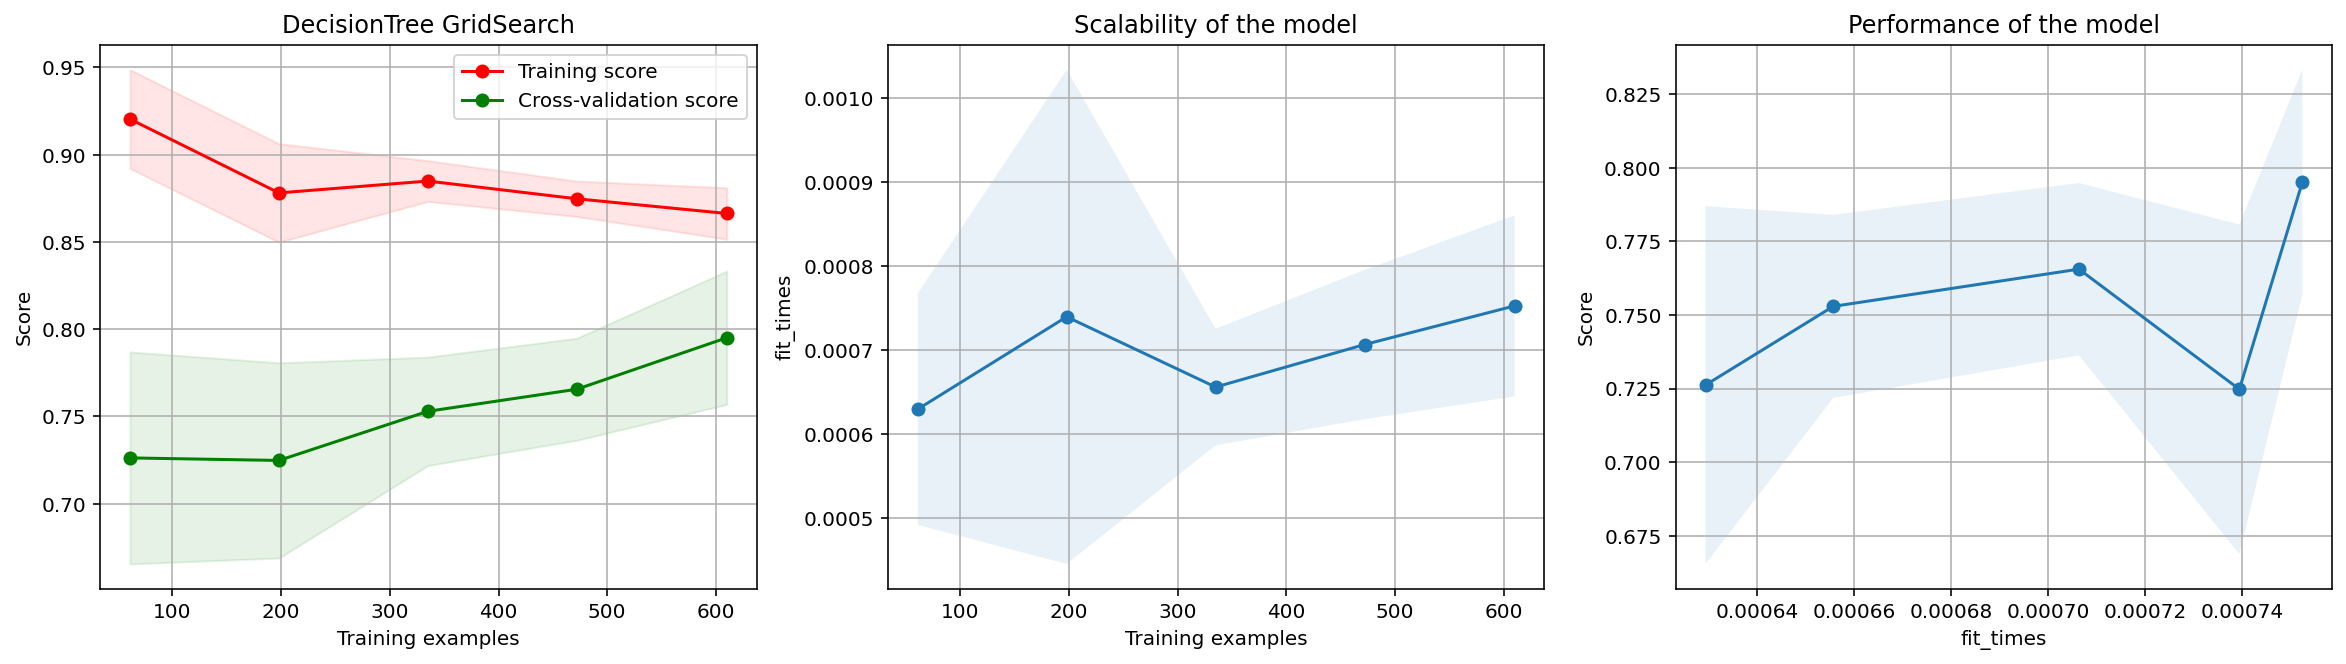

In [30]:
plot_learning_curve(gs2.best_estimator_, "DecisionTree GridSearch", X_train, y_train, cv=7);